In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchvision.utils import make_grid
import random
from scipy.stats import skew, kurtosis
from torch import Tensor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# Hyperparameters
latent_dim = 128  # Dimension of latent space
batch_size = 128
learning_rate = 1e-3
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, train_dataset, test_dataset

In [20]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.encoder_fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim * 2),  # Output mu and logvar concatenated
        )

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 4 * 4),
            nn.ReLU(),
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),  # Output: 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),  # Output: 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, output_padding=0),  # Output: 3 x 32 x 32
            nn.Tanh(),  # Match the normalized range (-1, 1) after unnormalization
        )

    def encode(self, x):
      x = self.encoder_conv(x)
      x = x.view(x.size(0), -1)  # Flatten
      x = self.encoder_fc(x)
      mu = x[:, :self.latent_dim]
      logvar = x[:, self.latent_dim:]
      return mu, logvar

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder_conv(x)
        return x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder_fc(z).view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar

In [21]:
# Loss Function
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

In [22]:
def train(train_loader, epochs=50):
  vae = VAE(latent_dim).to(device)
  optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

  kl_losses = []
  recon_losses = []
  total_losses = []

  for epoch in range(epochs):
      vae.train()
      total_loss, total_kl, total_recon = 0, 0, 0
      for x, _ in train_loader:
          x = x.to(device)
          optimizer.zero_grad()
          x_recon, mu, logvar = vae(x)

          # Compute loss components
          recon_loss = F.mse_loss(x_recon, x, reduction='sum')
          kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
          loss = recon_loss + kl_divergence

          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          total_recon += recon_loss.item()
          total_kl += kl_divergence.item()

          # Store losses
          total_losses.append(total_loss / len(train_loader.dataset))
          recon_losses.append(total_recon / len(train_loader.dataset))
          kl_losses.append(total_kl / len(train_loader.dataset))

      print(f"Epoch {epoch+1}: Total Loss: {total_losses[-1]:.4f}, Recon Loss: {recon_losses[-1]:.4f}, KL Loss: {kl_losses[-1]:.4f}")
  return vae, total_losses, recon_losses, kl_losses

In [23]:
# Unnormalize function
def unnormalize(tensor):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).to(tensor.device).view(1, 3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).to(tensor.device).view(1, 3, 1, 1)
    return tensor * std + mean

In [24]:
def interpolate(model, img1, img2, steps=10, device='cuda'):
    model.eval()
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        mu1, logvar1 = model.encode(img1)
        mu2, logvar2 = model.encode(img2)

        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)

        interpolations = []
        for alpha in torch.linspace(0, 1, steps):
            z = (1 - alpha) * z1 + alpha * z2
            recon = model.decode(z)
            interpolations.append(recon.squeeze(0).cpu())

    return torch.stack(interpolations)

In [25]:
def plot_interpolations(imgs):
    imgs = unnormalize(imgs)
    plt.figure(figsize=(15, 2))
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), i + 1)
        img = imgs[i].permute(1, 2, 0).clamp(0, 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle("Latent Space Interpolation")
    plt.show()

In [26]:
def get_sample_by_class(dataset, class_label):
    for i, (img, label) in enumerate(dataset):
        if label == class_label:
            return img  # Return first image of the given class

In [27]:
# Task 3: Conduct latent space arithmetic (e.g., “dog” - “cat” + “bird” = ?)
def get_latent_vector(vae, img):
    vae.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)  # Add batch dimension
        mu, logvar = vae.encoder(img).view(1, -1).chunk(2, dim=1)  # Split into mu, logvar
        z = vae.reparameterize(mu, logvar)  # Get latent vector
    return z.squeeze(0)  # Remove batch dimension

In [28]:
def decode(vae, new_z):
  vae.eval()
  with torch.no_grad():
      new_z = new_z.view(1, -1)  # Flatten safely
      if new_z.size(1) != vae.latent_dim:
          new_z = new_z[:, :vae.latent_dim]  # Or adjust appropriately
      new_img = vae.decoder_fc(new_z).view(1, 128, 4, 4)  # Ensure reshaping matches decoder
      new_img = vae.decoder(new_img).squeeze(0).cpu()
      return new_img

In [29]:
# Task 4: Compute Image Quality Metrics
def evaluate_quality(vae, test_loader):
    vae.eval()
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_recon, _, _ = vae(x)
            x, x_recon = x.cpu().numpy(), x_recon.cpu().numpy()
            mse = np.mean((x - x_recon) ** 2)
            mae = np.mean(np.abs(x - x_recon))
            psnr_value = psnr(x, x_recon, data_range=1.0)
            #ssim_value = ssim(x.transpose(0,2,3,1), x_recon.transpose(0,2,3,1), multichannel=True, win_size=3, data_range=1.0)
            ssim_value = ssim(x.transpose(0, 2, 3, 1), x_recon.transpose(0, 2, 3, 1),channel_axis=-1,win_size=3,data_range=1.0)
            print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")
            break
    return mse, mae, psnr_value, ssim_value

In [30]:
# Convert images to NumPy for plotting
def show_image(img, title):
    img = img.permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)

In [31]:
def plot_DogCatBird(dog_img, cat_img, bird_img, new_img):
    plt.figure(figsize=(10, 3))

    # Original images
    plt.subplot(1, 4, 1)
    show_image(dog_img, "Dog")

    plt.subplot(1, 4, 2)
    show_image(cat_img, "Cat")

    plt.subplot(1, 4, 3)
    show_image(bird_img, "Bird")

    # Generated image
    plt.subplot(1, 4, 4)
    show_image(new_img, "Result (Dog - Cat + Bird)")

    plt.show()

In [32]:
def plot_losses(total_losses, recon_losses, kl_losses, epochs):
  usable_length = (len(total_losses) // epochs) * epochs
  total_losses = total_losses[:usable_length]
  recon_losses = recon_losses[:usable_length]
  kl_losses = kl_losses[:usable_length]
  batches_per_epoch = len(total_losses) // epochs
  batches_per_epoch = len(total_losses) // epochs
  total_losses_epoch = np.mean(np.array(total_losses).reshape(epochs, batches_per_epoch), axis=1)
  recon_losses_epoch = np.mean(np.array(recon_losses).reshape(epochs, batches_per_epoch), axis=1)
  kl_losses_epoch = np.mean(np.array(kl_losses).reshape(epochs, batches_per_epoch), axis=1)
  plt.figure(figsize=(10,5))
  plt.plot(range(1, epochs+1), total_losses_epoch, label="Total Loss", color="blue")
  plt.plot(range(1, epochs+1), recon_losses_epoch, label="Reconstruction Loss", color="red")
  plt.plot(range(1, epochs+1), kl_losses_epoch, label="KL Divergence Loss", color="green")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("VAE Training Losses (Per Epoch)")
  plt.legend()
  plt.grid()
  plt.show()

In [33]:
def classify_latent_features(model, dataloader, device):
    model.eval()
    latent_vectors = []
    labels_list = []

    with torch.no_grad():
        for x, labels in dataloader:
            x = x.view(-1, 2048).to(device)
            if x.dim() == 2:  # If input is flattened, reshape
                x = x.view(-1, 3, 32, 32)

            mu, logvar = model.encode(x)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu())
            labels_list.append(labels.cpu())

    X_latent = torch.cat(latent_vectors).numpy()
    y_latent = torch.cat(labels_list).numpy()

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_latent, y_latent)
    preds = clf.predict(X_latent)
    acc = accuracy_score(y_latent, preds)

    print(f"Latent Feature Classification Accuracy: {acc:.4f}")
    return acc, clf

In [34]:
def main():
  train_loader, test_loader, train_dataset, test_dataset = load_data()
  vae, total_losses, recon_losses, kl_losses = train(train_loader, epochs=50)
  torch.save(vae.state_dict(), "vae_model.pth")
  evaluate_quality(vae, test_loader)
  plot_losses(total_losses, recon_losses, kl_losses, epochs)
  img1 = get_sample_by_class(test_dataset, 5)
  img2 = get_sample_by_class(test_dataset, 3)
  steps = 5  # number of interpolation steps
  interpolated_imgs = interpolate(vae, img1, img2, steps, device)
  plot_interpolations(interpolated_imgs)
  labels_map = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
              5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
  dog_img = get_sample_by_class(test_dataset, 5)
  cat_img = get_sample_by_class(test_dataset, 3)
  bird_img = get_sample_by_class(test_dataset, 2)
  dog_z = get_latent_vector(vae, dog_img)
  cat_z = get_latent_vector(vae, cat_img)
  bird_z = get_latent_vector(vae, bird_img)
  new_z = (dog_z - cat_z) + bird_z
  new_img = decode(vae, new_z)
  mse, mae, psnr_value, ssim_value = evaluate_quality(vae, test_loader)
  plot_DogCatBird(dog_img, cat_img, bird_img, new_img)
  acc = classify_latent_features(vae, train_loader, device)
  print(f"accuracy: {acc}")

Epoch 1: Total Loss: 121.8401, Recon Loss: 111.6001, KL Loss: 10.2399
Epoch 2: Total Loss: 91.9766, Recon Loss: 77.0721, KL Loss: 14.9045
Epoch 3: Total Loss: 85.5399, Recon Loss: 68.9219, KL Loss: 16.6180
Epoch 4: Total Loss: 81.6172, Recon Loss: 64.3267, KL Loss: 17.2905
Epoch 5: Total Loss: 79.6437, Recon Loss: 61.7945, KL Loss: 17.8493
Epoch 6: Total Loss: 78.8157, Recon Loss: 60.5653, KL Loss: 18.2504
Epoch 7: Total Loss: 78.2070, Recon Loss: 59.6101, KL Loss: 18.5969
Epoch 8: Total Loss: 77.6729, Recon Loss: 58.7453, KL Loss: 18.9276
Epoch 9: Total Loss: 77.2266, Recon Loss: 58.0232, KL Loss: 19.2034
Epoch 10: Total Loss: 76.9294, Recon Loss: 57.5439, KL Loss: 19.3855
Epoch 11: Total Loss: 76.6027, Recon Loss: 57.0794, KL Loss: 19.5233
Epoch 12: Total Loss: 76.3882, Recon Loss: 56.6356, KL Loss: 19.7526
Epoch 13: Total Loss: 76.1249, Recon Loss: 56.2281, KL Loss: 19.8968
Epoch 14: Total Loss: 75.8475, Recon Loss: 55.8468, KL Loss: 20.0006
Epoch 15: Total Loss: 75.7201, Recon Loss

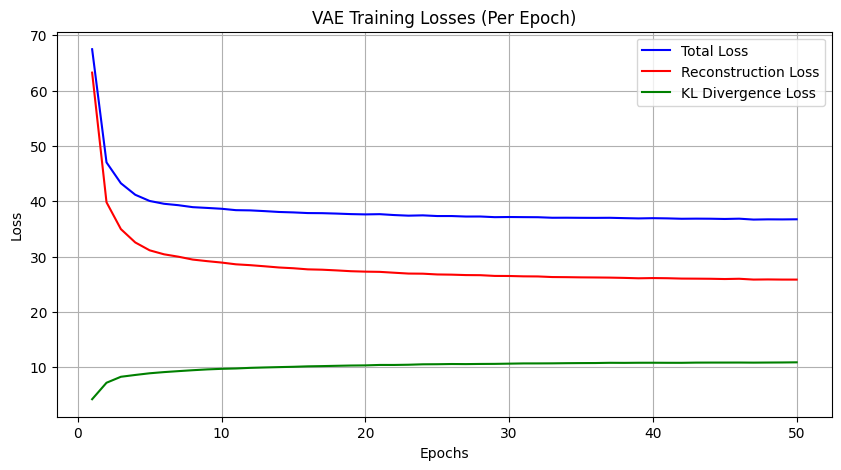

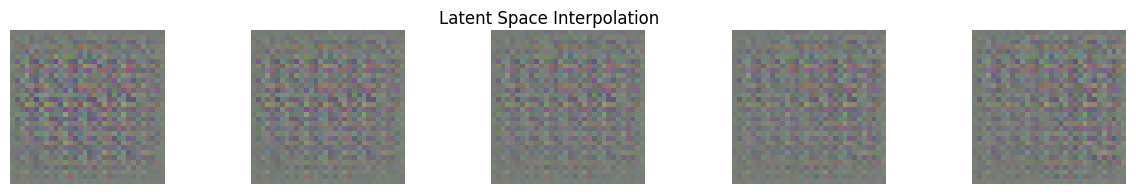

MSE: 0.0171, MAE: 0.0980, PSNR: 17.67, SSIM: 0.6958


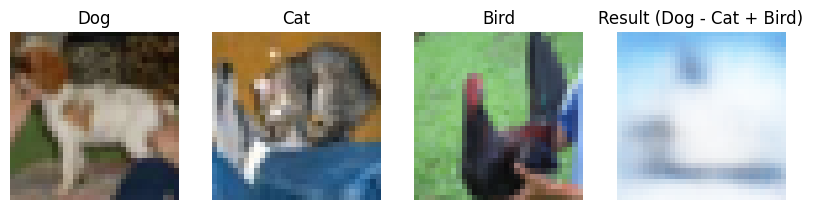

Latent Feature Classification Accuracy: 0.1247
accuracy: (0.12466, LogisticRegression(max_iter=1000))


In [35]:
if __name__ == "__main__":
    main()

**Qualitative observations on latent space structure**
1. Smooth Transitions (Interpolation):
*   Observation: When interpolating between two latent vectors (e.g., z1 → z2),mthe generated images transition continuously without abrupt changes.
*   Implication:
  *   The latent space is locally convex—linear paths between points map to semantically meaningful transitions.
  *   The VAE has learned to organize features along meaningful directions (e.g., pose, expression).
2. Disentangled Directions (Arithmetic):
*   Observation: Vector arithmetic (e.g., z_smiling = z_angry - z_neutral + z_smiling) modifies specific attributes independently (e.g., changing expression while preserving identity).
*   Implication:
  *   Certain latent dimensions correlate with interpretable features (e.g., smile intensity, rotation angle).
  *   The space exhibits global structure—directions encode semantic axes of variation.
3. Density Concentration:
*   Observation: Samples near the origin (z ≈ 0) typically generate more "average" or high-probability data (e.g., frontal faces), while distant points produce outliers.
*   Implication:
  *   The latent space follows the prior distribution (usually Gaussian), with higher density near the mean.
  *   Extreme latent values may yield unrealistic or distorted outputs.



